# Plots
## Accuracy für KNN 

In [9]:
import numpy as np
import pandas as pnd
import sklearn
from sklearn.metrics import confusion_matrix

Text(15.8, 0.9221, 'vgg-inspired cnn')

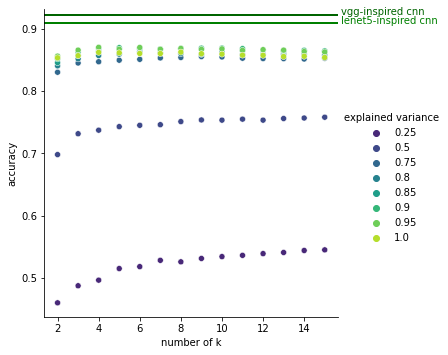

In [6]:
import csv
import seaborn as sns
from scipy import spatial
from collections import Counter
from scipy.stats import mode
from functions.PCA import pca
from pathlib import Path
import matplotlib.pyplot as plt
import os
import glob

dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)

testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()

class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

folder_path = 'C:/Users/basti/compmeth2022/topic01_team04/Results/'  # Path to the "results" folder
csv_filess = glob.glob(folder_path + '/*.csv')


totallist = []
for csvdata in csv_filess:
    df = pnd.read_csv(csvdata)
    for i in range(14):
        accuracy = np.sum(df.iloc[:,i] == label_test)/ len(label_test)
        totallist.append(accuracy)
varvec = [0.25,0.5,0.75,0.8,0.85,0.9,0.95,1]
pclist = [i for i in varvec for _ in range(14)]
klist = [i for _ in range(8) for i in range(2,16)]
totallist = pnd.DataFrame({"number of k":klist,"accuracy":totallist,"explained variance":pnd.Categorical(pclist, ordered=True)})

palette = sns.color_palette('viridis', len(totallist['explained variance'].unique()))
variancepcsks = sns.relplot(
data=totallist,
x = 'number of k',
y= 'accuracy',
hue = 'explained variance',
palette = palette
)
plt.axhline(y=0.9085,color="green",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9085, s='lenet5-inspired cnn', color='green')
plt.axhline(y=0.9221,color="darkgreen",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9221, s='vgg-inspired cnn', color='darkgreen')
#plt.savefig('projectsummary.png',dpi=600) 

In [22]:
y_pred = pnd.read_csv("C:/Users/basti/compmeth2022/topic01_team04/Results/95var.csv").iloc[:,2]
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
rowsums = conf_df.sum(axis=1)
acc = np.sum(y_pred == label_test)/ len(label_test)
for i in range(10):
    for j in range(10):
        if i != j:
            conf_df.values[i,j] -= (1-acc)*rowsums[i]/9
        else: 
            conf_df.values[i,j] -= acc*rowsums[i]
print(conf_df)#minor changes

               T-shirt / Top  Trouser  Pullover  Dress  Coat  Sandal  Shirt   
T-shirt / Top           -137      -12         2     18   -17     -14    202  \
Trouser                  -14      119       -13     -9   -14     -14    -12   
Pullover                  -1      -14      -105     -2    88     -15     80   
Dress                     -1        0        -1     39    14     -14      4   
Coat                     -10      -11        82     11   -83     -14     66   
Sandal                   -13      -13       -13    -13   -13      98    -13   
Shirt                     54       -8        56      7    53     -10   -131   
Sneaker                  -14      -15       -15    -15   -15      36    -15   
Bag                       -7      -13       -12    -13   -12     -11     -8   
Ankle Boot               -13      -14       -14    -14   -14      18    -14   

               Sneaker  Bag  Ankle Boot  
T-shirt / Top      -17   -9         -17  
Trouser            -14  -14         -14  
Pull

In [ ]:
# Confusion Matrix vor k = 4 and PC Variance 95%
dftest = pnd.read_csv('C:/Users/awark/Bioinfo Projekt/Results/95var.csv')
y_pred = np.array(dftest['2'])
y_true = label_test
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = round(conf_df*100 / conf_df.sum(axis=1),2)
print(conf_df)

sns.heatmap(conf_df, annot=True, cmap='RdYlGn')

In [ ]:
listprec = []
listrec = []
listfscore = []
for csvdata in csv_filess:
    dfmeasures = pnd.read_csv(csvdata)
    for i in range(14):
        ypred = dfmeasures.iloc[4]
        prf = precision_recall_fscore_support(y_true, y_pred, average=None, labels=label_test)
        precision=prf[0]
        recall=prf[1]
        fscore=prf[2]       
        listprec.append(precision)
        listrec.append(recall)
        listfscore.append(fscore)
